In [1]:
import os
import numpy as np
np.random.seed(420)
from datetime import datetime
from tqdm import tnrange, tqdm_notebook

from HMM_helper import parse_text
from keras.utils import to_categorical

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F

Using TensorFlow backend.


# Data processing

In [2]:
with open(os.path.join(os.getcwd(), 'data/shakespeare.txt'), 'r') as f:
    text = f.read()

with open(os.path.join(os.getcwd(), 'data/Syllable_dictionary.txt'), 'r') as f:
    syll_map0 = {}
    for i, line in enumerate(f):
        line = line.strip().split()
        word = line[0] 
        # Add 10 to denote end of line syll_count
        sylls = np.array([int(s.replace('E', '1')) for s in line[1:]])
        assert(word not in syll_map0)
        syll_map0[word] = sylls

sonnets = parse_text(text, by='sonnet')
chars = sorted(list(set("".join(sonnets))))
char_to_int = dict((c, i) for i,c in enumerate(chars))
num_chars = len(char_to_int)

In [3]:
# source: https://blog.usejournal.com/how-to-develop-a-character-based-neural-language-model-99c18de1d4d2
# organize into sequences of characters
def make_data(step, length = 40, seqs=sonnets, char_to_int=char_to_int):
    char_seqs = list()
    for curr in seqs:
        for i in range(length, len(curr), step):
            # select sequence of tokens
            seq = curr[i-length:i+1]
            # store
            char_seqs.append(seq)

    # convert sequences of characters into sequences of integers using the mapping dictionary
    int_seqs = list()
    for seq in char_seqs:
        new_seq = [char_to_int[char] for char in seq]
        int_seqs.append(new_seq)
    
    int_seqs = np.array(int_seqs)
    train_X = int_seqs[:, :-1]
    train_Y = int_seqs[:, 1:]
    return train_X, train_Y

In [4]:
BATCH_SIZE = 160 # 80 = 22s/it, 100 = 19s/it, 160-200 = 18.5s/it, 400 = 20s/it
N_EPOCH = 100
STEP = 3
LENGTH = 40

X, Y = make_data(STEP, length=LENGTH)
train_X = torch.Tensor(np.array([to_categorical(x, num_classes = num_chars) for x in X]))
train_Y = torch.Tensor(Y).long()

train_loader = data.DataLoader(list(zip(train_X, train_Y)), batch_size=BATCH_SIZE, shuffle=False)

# Model

In [5]:
class CharLSTM(nn.Module):
    def __init__(self, n_units=150, char_to_int=char_to_int):
        super().__init__()
        self.char2int = char_to_int
        self.int2char = {i:c for (c,i) in char_to_int.items()}
        self.num_chars = len(char_to_int)
        self.lstm = nn.LSTM(self.num_chars, hidden_size=n_units, batch_first=True)
        self.fc1 = nn.Linear(n_units, self.num_chars)
        self.n_hidden = n_units
        
    def init_h(self, batch_size=BATCH_SIZE):
        return (torch.zeros(1, batch_size, self.n_hidden), ) * 2
        
    def forward(self, x, bs=BATCH_SIZE, h=None):
        if h is None:
            h = self.init_h(bs) 
        lstm_out, h = self.lstm(x, h)
        return self.fc1(lstm_out.contiguous().view(-1, self.n_hidden)), h
    
    def gen_seq(self, seed, n_chars, top_k=None, temp=1.0, verbose=False):
        self.eval()
        
        text = seed
        top_k = top_k if top_k else self.num_chars
        encoded = to_categorical(np.array([self.char2int[c] for c in seed]), self.num_chars)
        x = torch.Tensor(encoded).view(1, -1, self.num_chars)
        h = self.init_h(1)
        
        with torch.no_grad():
            for i in tnrange(n_chars, desc='which char'):
                out, h = self.forward(x, h=h)
                p, inds = F.softmax(out[-1] / temp, dim=0).topk(top_k) 
                ind = np.random.choice(inds.numpy(), p=(p / p.sum()).numpy())
                text += self.int2char[ind]
                x = torch.Tensor(to_categorical(ind, self.num_chars)).view(1, 1, -1)
            
        return text
        

model = CharLSTM()

## Training

In [16]:
tol = -1e-1
accs = [0.0]
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

model.train()
for i in tnrange(N_EPOCH, desc='epoch'):
    
    running_loss = 0.0
    running_acc = 0.0
    
    for (x, y) in tqdm_notebook(train_loader, desc='batch', leave=False):
        model.zero_grad()
        out, h = model(x, bs=len(x))
        y = y.reshape(-1)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_acc += (torch.argmax(out, 1) == y).data.numpy().sum()
        
    e_loss = running_loss * (BATCH_SIZE / len(train_X)) # running_loss * n_batches
    accs.append(running_acc / np.prod(train_X.shape[:-1]))
    print(f'epoch {i}: loss={e_loss}, acc={accs[-1]}')
    if accs[-1] <= accs[-2] + tol:
        break    

epoch 0: loss=1.1766415124619052, acc=0.6208857132624189


epoch 1: loss=1.157319298199035, acc=0.6273432183661044


epoch 2: loss=1.150283382425745, acc=0.6293193295369077


epoch 3: loss=1.1461306074270952, acc=0.6309686257655528


epoch 4: loss=1.146337419256244, acc=0.6292709788331363


epoch 5: loss=1.14402195601318, acc=0.6306328569893629


epoch 6: loss=1.138474662966298, acc=0.6320412950825544


epoch 7: loss=1.1321924808762194, acc=0.6339180186956055


epoch 8: loss=1.127288141794035, acc=0.6348904050714516


epoch 9: loss=1.1236751066323811, acc=0.6366569965259123


epoch 10: loss=1.1208821893707523, acc=0.6374180724186096


epoch 11: loss=1.118921845396714, acc=0.6371772142831561


epoch 12: loss=1.113054934316829, acc=0.6396520540095268


epoch 13: loss=1.1088693202137498, acc=0.6411643565774865


epoch 14: loss=1.1055814432152566, acc=0.6416120482790731


epoch 15: loss=1.1024626771527868, acc=0.643989291214498


epoch 16: loss=1.0996215628081596, acc=0.6432747752587658


epoch 17: loss=1.099555601103122, acc=0.6439678020128219


epoch 18: loss=1.093264722170006, acc=0.646418466387307


epoch 19: loss=1.0955831347980214, acc=0.6446679918341034


epoch 20: loss=1.0904718363320502, acc=0.6465715769492497


epoch 21: loss=1.0924391068350316, acc=0.6451720926900899


epoch 22: loss=1.0887904853885015, acc=0.6468589950216683


epoch 23: loss=1.0826395241161595, acc=0.6496319974212958


epoch 24: loss=1.0811001193680951, acc=0.6498692740231367


epoch 25: loss=1.075990847729026, acc=0.6516528777622578


epoch 26: loss=1.0717241410808453, acc=0.6534642383868773


epoch 27: loss=1.0762954281682993, acc=0.6513887396583217


epoch 28: loss=1.07536163888873, acc=0.6503859102467676


epoch 29: loss=1.0723641121875487, acc=0.6516260162601626


epoch 30: loss=1.068204347471048, acc=0.6542512803982665


epoch 31: loss=1.0634097388299522, acc=0.6548422334443609


epoch 32: loss=1.0615845603692848, acc=0.6554278141900362


epoch 33: loss=1.0591272759423045, acc=0.6565049604240536


epoch 34: loss=1.056376378621017, acc=0.657975179972064


epoch 35: loss=1.0594714857318468, acc=0.6558987858601053


epoch 36: loss=1.0537670784191955, acc=0.6580871028974606


epoch 37: loss=1.0524667613695287, acc=0.6585661330181584


epoch 38: loss=1.0498334422100752, acc=0.6595850793309695


epoch 39: loss=1.0435927595203651, acc=0.6607589269725297


epoch 40: loss=1.0498647804925616, acc=0.6590165108699545


epoch 41: loss=1.0458942528914545, acc=0.6598053436481501


epoch 42: loss=1.043049424405315, acc=0.6617966763368074


epoch 43: loss=1.0366541922363552, acc=0.6641479531535404


epoch 44: loss=1.0374766208010235, acc=0.6634029941621002


epoch 45: loss=1.041199838631406, acc=0.6615128397980015


epoch 46: loss=1.0413113800324263, acc=0.6612137817413416


epoch 47: loss=1.0327607779869876, acc=0.6650146842878121


epoch 48: loss=1.0295777238716237, acc=0.6658008309157981


epoch 49: loss=1.0250279756625742, acc=0.6665556391246732


epoch 50: loss=1.0261145902181235, acc=0.6680410801905375


epoch 51: loss=1.0246099424432202, acc=0.6672334443608753


epoch 52: loss=1.0295327665009892, acc=0.665128397980015


epoch 53: loss=1.026049751909392, acc=0.6668314172128506


epoch 54: loss=1.0272088875201357, acc=0.666802764943949


epoch 55: loss=1.0229621362704944, acc=0.6675092224490526


epoch 56: loss=1.0177040352853286, acc=0.6693537122595895


epoch 57: loss=1.015324513860369, acc=0.6703153540345976


epoch 58: loss=1.0130749429853252, acc=0.6706914150639304


epoch 59: loss=1.017005160162209, acc=0.6702383510619248


epoch 60: loss=1.0179170771991919, acc=0.6695381612406432


epoch 61: loss=1.012715630363775, acc=0.670591132122775


epoch 62: loss=1.0098111809232908, acc=0.6718303427527668


epoch 63: loss=1.0093726758641648, acc=0.6719091364922459


epoch 64: loss=1.0059597500671669, acc=0.6735503742702625


epoch 65: loss=1.012449032264437, acc=0.6709815192865585


epoch 66: loss=1.0073834870077727, acc=0.672885999785108


epoch 67: loss=1.0041817744034998, acc=0.6739335983668207


epoch 68: loss=1.0041711818932386, acc=0.6750931198739301


epoch 69: loss=1.0021902595121894, acc=0.674653486622972


epoch 70: loss=1.0032884311481336, acc=0.6742693671430107


epoch 71: loss=1.0057613450952043, acc=0.6738601769277605


epoch 72: loss=1.005620523320711, acc=0.6734017406253358


epoch 73: loss=1.0002163446101977, acc=0.6754781347372945


epoch 74: loss=0.9978669960593337, acc=0.6766242254933562


epoch 75: loss=0.9932882120349611, acc=0.6771229540489238


epoch 76: loss=0.9929692125701276, acc=0.6778007592851258


epoch 77: loss=0.9976924221860889, acc=0.6751531105619426


epoch 78: loss=0.9954163181180193, acc=0.6768677697790194


epoch 79: loss=0.9936043997641932, acc=0.6770477418430572


epoch 80: loss=0.9930524368015616, acc=0.6773378460656854


epoch 81: loss=0.9899625644647633, acc=0.6785036352566168


epoch 82: loss=0.9921708620532588, acc=0.6782833709394362


epoch 83: loss=0.9894183084994724, acc=0.6789665484760574


epoch 84: loss=0.987076812792779, acc=0.679718670534723


epoch 85: loss=0.9842677458126485, acc=0.6811897854661366


epoch 86: loss=0.978471079962604, acc=0.6828390816947817


epoch 87: loss=0.9796570708590205, acc=0.6823421439060205


epoch 88: loss=0.9788578254505973, acc=0.6824236237957093


epoch 89: loss=0.9760478389864728, acc=0.682675226532001


epoch 90: loss=0.9833987880105776, acc=0.6801278607499731


epoch 91: loss=0.985381008325942, acc=0.6796891228824182


epoch 92: loss=0.9810167595230189, acc=0.6813473729450951


epoch 93: loss=0.9744013956447781, acc=0.6835052469467426


epoch 94: loss=0.9787454362935321, acc=0.6819481752086244


epoch 95: loss=0.9771957703500187, acc=0.6819410121413989


epoch 96: loss=0.9733307347513365, acc=0.6844051072669317


epoch 97: loss=0.9727694013860702, acc=0.6842188675190717


epoch 98: loss=0.9760006143295262, acc=0.6832160381075176


epoch 99: loss=0.9753871979342333, acc=0.6834148132230221



## Saving

In [17]:
fName = datetime.today().strftime('%y%m%d_%H%M') + f"_rnn_torch.net"
torch.save(model.state_dict(), fName)

In [18]:
model = CharLSTM()
model.load_state_dict(torch.load(fName));

## Generation

In [25]:
start = np.random.randint(0, len(train_X) - 1)
pattern = ''.join([model.int2char[value] for value in X[start]])
gen = model.gen_seq(pattern, n_chars=80, top_k=5, temp=0.2)
print(f'seed: {pattern}')
print(f'generated: {gen}')


seed: e nor the gilded monuments of princes sh
generated: e nor the gilded monuments of princes shall i my mistress' that i am not be stole it self sorrows your self with thee th


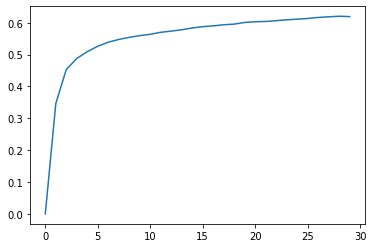

In [12]:
import matplotlib.pyplot as plt
plt.plot(accs)

In [13]:
model.eval()
with torch.no_grad():
    out, _ = model(train_X, bs=len(train_X))
    print((torch.argmax(out, 1) == train_Y.reshape(-1)).data.numpy().mean())

0.6074155653450808
